In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PDS import PDS as pds

# Обработка результатов

## **Изучение полученных результатов из УМ**

In [ ]:
pds.get_profile_results("loaded","curve_350","ellips10",60,force="side")

In [ ]:
pds.get_speed_results("loaded","straight","normal","greb_24","vertical")

In [ ]:

wagon_cfg = ["empty","loaded"]
way_cfg = ["straight","curve_350","curve_650"]
wheel_cfg = ["gost", "greb_26","greb_28","greb_30","newwagonw", "greb_24"]
fault_cfg = ["normal","polzun15","ellips10"]

ALL_CALCULATIONS_VERTICAL = pds.get_full_calculations(wagon_cfg,way_cfg,wheel_cfg,fault_cfg,force="vertical")

ALL_CALCULATIONS_SIDE = pds.get_full_calculations(wagon_cfg,way_cfg,wheel_cfg,fault_cfg,force="side")

## **Подготовка инфы для разделения на кастомные фолды**

Так как колесо по ГОСТ имеет радиус 475 мм, то полный оборот колеса fold = 2*pi*475

Тогда время прохождения полного оборота колеса будет равно t = fold/v 

In [ ]:
def time_split(v:int) -> int:
    """Определение временного промежутка полного оборота колеса
    1. v - скорость движения поезда, км/ч
    """
    speed = v/3.6
    lenght = 2*np.pi*0.475
    t = lenght/speed
    return t

In [ ]:
plt.grid(True)
sns.lineplot(ALL_CALCULATIONS_VERTICAL["empty"]["straight"]["normal"]["gost"][0])
plt.show()

In [ ]:
pds.time_indexes(ALL_CALCULATIONS_VERTICAL["empty"]["straight"]["normal"]["greb_24"])

In [ ]:
ALL_TIME_INDEXES = pds.get_all_time_indexes(ALL_CALCULATIONS_VERTICAL)

In [ ]:
plt.figure().set_size_inches(12,8)
plt.grid(True)
sns.lineplot(ALL_CALCULATIONS_VERTICAL["loaded"]["straight"]["normal"]["gost"][1])
plt.title("Не разделенный расчет")
plt.ylabel("Вертикальная сила, Н")
plt.xlabel("Время, с")
plt.show()

**Пример разделения расчета на несколько мелких по обороту колеса**

In [ ]:
devided_result = pds.get_splitted_dataframe(ALL_CALCULATIONS_VERTICAL["loaded"]["straight"]["normal"]["gost"][1],
                                       ALL_TIME_INDEXES["loaded"]["straight"]["normal"]["gost"]["20"])

devided_result_ = pds.get_splitted_dataframe(ALL_CALCULATIONS_SIDE["loaded"]["straight"]["normal"]["gost"][1],
                                       ALL_TIME_INDEXES["loaded"]["straight"]["normal"]["gost"]["20"])

plt.figure().set_size_inches(12,8)
plt.grid(True)
plt.plot(devided_result)
plt.ylabel("Вертикальная сила, Н")
plt.xlabel("Время, с")
plt.title("Раздедение одного расчета по полному обороту колеса")
plt.xlim(0,5)
plt.ylim(0,225000)
plt.show()

In [ ]:
# ЗАПУСТИТЬ ЭТИ ЯЧЕЙКИ

df_vertical = pds.make_frame_from_splits(ALL_CALCULATIONS_VERTICAL,ALL_TIME_INDEXES)
DF_VERTICAL = pds.make_pretty_df(df_vertical,"data_new_raw_vertical.parquet",True)

In [ ]:
df_side = pds.make_frame_from_splits(ALL_CALCULATIONS_SIDE,ALL_TIME_INDEXES)
DF_SIDE = pds.make_pretty_df(df_side,"data_new_raw_side.parquet",True)

# Подгрузка сохраненных результатов

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PDS import PDS as pds

In [2]:
# DF = df_
DF_SIDE = pd.read_parquet("data_new_raw_side.parquet")
DF_VERTICAL = pd.read_parquet("data_new_raw_vertical.parquet")

In [3]:
DF_SIDE.head()

25%         50%        75%  count  \
empty_straight_normal_10_gost 0 -11091.2945  -7695.0806 -5090.5459  215.0   
                              1 -11988.8725  -8809.9502 -6249.2637  215.0   
                              2 -14041.4210 -10742.7880 -7864.0198  215.0   
                              3 -12863.9020  -9595.0107 -6922.1643  215.0   
                              4 -12899.4970 -10761.9910 -8761.3857  215.0   

                                     kurt         max          mean  \
empty_straight_normal_10_gost 0 -0.233897  4572.97410  -7727.353586   
                              1 -0.960363 -2141.21260  -9108.305539   
                              2 -0.813141 -1299.67530 -11051.330162   
                              3 -0.622037   139.41061  -9705.199496   
                              4 -0.390614 -3988.28860 -11032.573618   

                                       min      skew          std  \
empty_straight_normal_10_gost 0 -16595.238  0.312691  4381.332844   
                              1 -16471.590 -0.236408  3683.999205   
                              2 -20610.469 -0.120031  3959.602067   
                              3 -19541.955  0.042085  3892.656564   
                              4 -18987.340 -0.260762  3119.499045   

                                          sum           var  
empty_straight_normal_10_gost 0 -1.661381e+06  1.919608e+07  
                              1 -1.958286e+06  1.357185e+07  
                              2 -2.376036e+06  1.567845e+07  
                              3 -2.086618e+06  1.515278e+07  
                              4 -2.372003e+06  9.731274e+06

In [4]:
DF_VERTICAL.head()

25%        50%         75%  count  \
empty_straight_normal_10_gost 0  126248.195  127004.93  127457.270  215.0   
                              1  127451.105  127666.25  128031.975  215.0   
                              2  127705.360  128518.85  130617.665  215.0   
                              3  126194.690  127737.66  128519.410  215.0   
                              4  126548.895  126879.16  127545.775  215.0   

                                     kurt        max           mean  \
empty_straight_normal_10_gost 0  0.712095  128489.06  126760.678000   
                              1 -0.154321  128716.65  127687.467349   
                              2 -1.200553  132194.30  129000.508791   
                              3 -0.551838  131944.66  127570.362279   
                              4  0.913185  129705.06  127062.812000   

                                       min      skew          std  \
empty_straight_normal_10_gost 0  123032.87 -0.803691   916.289112   
                              1  126435.99 -0.283763   439.892909   
                              2  126678.78  0.375457  1505.297634   
                              3  124110.58  0.091421  1621.369411   
                              4  125834.34  1.052079   714.953224   

                                         sum           var  
empty_straight_normal_10_gost 0  27253545.77  8.395857e+05  
                              1  27452805.48  1.935058e+05  
                              2  27735109.39  2.265921e+06  
                              3  27427627.89  2.628839e+06  
                              4  27318504.58  5.111581e+05

In [5]:
DF_VERTICAL.shape

(359544, 12)

In [6]:
DF_SIDE = pds.delete_unvalid_cols(DF_SIDE)
DF_VERTICAL = pds.delete_unvalid_cols(DF_VERTICAL)

DF_VERTICAL.head(15)
# print(df.shape)

25%        50%         75%  count  \
empty_straight_normal_10_gost 0   126248.1950  127004.93  127457.270  215.0   
                              1   127451.1050  127666.25  128031.975  215.0   
                              2   127705.3600  128518.85  130617.665  215.0   
                              3   126194.6900  127737.66  128519.410  215.0   
                              4   126548.8950  126879.16  127545.775  215.0   
                              5   126508.6550  127269.22  128522.040  215.0   
                              6   127270.6550  131287.77  132180.030  215.0   
                              7   123335.9950  124113.06  124728.555  215.0   
                              8   122561.4125  124238.14  124826.245  214.0   
                              9   122923.5400  124045.73  125428.210  215.0   
                              10  121969.4700  122939.63  123993.310  215.0   
                              11  123485.2750  124511.16  126549.245  215.0   
                              12  125903.2350  127338.70  128225.595  215.0   
                              13  122365.2850  123283.09  123788.095  215.0   
                              14  123238.4100  124293.09  126030.575  215.0   

                                       kurt        max           mean  \
empty_straight_normal_10_gost 0    0.712095  128489.06  126760.678000   
                              1   -0.154321  128716.65  127687.467349   
                              2   -1.200553  132194.30  129000.508791   
                              3   -0.551838  131944.66  127570.362279   
                              4    0.913185  129705.06  127062.812000   
                              5   -0.424134  131159.64  127612.129488   
                              6   -0.917315  134591.02  130195.758093   
                              7    0.190340  127695.05  124161.085581   
                              8   -0.317501  128177.18  123816.053645   
                              9    6.953195  134962.42  124085.049907   
                              10   2.661525  129143.33  122891.310047   
                              11   1.966523  131474.67  124767.863302   
                              12   1.322861  130707.06  126896.269442   
                              13   0.017815  125005.11  123010.603395   
                              14  21.328424  133385.08  119873.574175   

                                           min      skew           std  \
empty_straight_normal_10_gost 0   123032.87000 -0.803691    916.289112   
                              1   126435.99000 -0.283763    439.892909   
                              2   126678.78000  0.375457   1505.297634   
                              3   124110.58000  0.091421   1621.369411   
                              4   125834.34000  1.052079    714.953224   
                              5   125634.27000  0.714055   1345.966395   
                              6   124305.92000 -0.573006   2765.339186   
                              7   121648.42000  0.594783   1204.612356   
                              8   119859.16000 -0.378228   1596.119046   
                              9   114752.05000  0.364874   2101.677845   
                              10  117129.39000  0.052280   1321.856338   
                              11  114270.15000 -0.740337   3248.966831   
                              12  119040.67000 -1.101457   2238.602534   
                              13  119567.49000 -0.708412   1074.399933   
                              14     585.20856 -4.800373  23522.432303   

                                           sum           var  
empty_straight_normal_10_gost 0   2.725355e+07  8.395857e+05  
                              1   2.745281e+07  1.935058e+05  
                              2   2.773511e+07  2.265921e+06  
                              3   2.742763e+07  2.628839e+06  
                              4   2.731850e+07  5.111581e+05  
                              5   2.743661e+0

In [7]:
pds.new_str("loaded_curve_650_normal_30_greb_30")

'loaded_curve650_normal_30_greb30'

In [8]:
DF_VERTICAL = DF_VERTICAL.reset_index().drop(["level_1"], axis=1)
DF_SIDE = DF_SIDE.reset_index().drop(["level_1"], axis=1)

DF_SIDE.head(15)

,level_0,25%,50%,75%,count,kurt,max,mean,min,skew,std,sum,var
0,empty_straight_normal_10_gost,-11091.294500,-7695.080600,-5090.545900,215.0,-0.233897,4572.97410,-7727.353586,-16595.2380,0.312691,4381.332844,-1.661381e+06,1.919608e+07
1,empty_straight_normal_10_gost,-11988.872500,-8809.950200,-6249.263700,215.0,-0.960363,-2141.21260,-9108.305539,-16471.5900,-0.236408,3683.999205,-1.958286e+06,1.357185e+07
2,empty_straight_normal_10_gost,-14041.421000,-10742.788000,-7864.019800,215.0,-0.813141,-1299.67530,-11051.330162,-20610.4690,-0.120031,3959.602067,-2.376036e+06,1.567845e+07
3,empty_straight_normal_10_gost,-12863.902000,-9595.010700,-6922.164300,215.0,-0.622037,139.41061,-9705.199496,-19541.9550,0.042085,3892.656564,-2.086618e+06,1.515278e+07
4,empty_straight_normal_10_gost,-12899.497000,-10761.991000,-8761.385700,215.0,-0.390614,-3988.28860,-11032.573618,-18987.3400,-0.260762,3119.499045,-2.372003e+06,9.731274e+06
5,empty_straight_normal_10_gost,-13097.301000,-9830.884800,-7148.135500,215.0,-0.616993,479.65393,-10180.788116,-18235.9410,-0.209667,3782.509348,-2.188869e+06,1.430738e+07
6,empty_straight_normal_10_gost,-14894.045500,-10027.831000,-4936.648200,215.0,-0.681952,6537.62450,-9241.848777,-22350.4960,0.391245,6671.642927,-1.986997e+06,4.451082e+07
7,empty_straight_normal_10_gost,490.712815,3432.152300,6846.407250,215.0,-0.261675,15798.46100,3362.091030,-9454.7324,-0.255321,5057.532483,7.228496e+05,2.557863e+07
8,empty_straight_normal_10_gost,1020.031563,4875.159450,6794.652825,214.0,0.406558,12882.93200,3719.417329,-11208.3440,-0.894887,4586.887927,7.959553e+05,2.103954e+07
9,empty_straight_normal_10_gost,-6805.733650,-1971.752900,1704.244000,215.0,-0.533796,7790.15040,-2624.330083,-17222.5140,-0.440929,5197.746589,-5.642310e+05,2.701657e+07


In [9]:
DF_VERTICAL["level_0"] = DF_VERTICAL["level_0"].map(pds.new_str)
DF_SIDE["level_0"] = DF_SIDE["level_0"].map(pds.new_str)

In [10]:
DF_VERTICAL.head()

,level_0,25%,50%,75%,count,kurt,max,mean,min,skew,std,sum,var
0,empty_straight_normal_10_gost,126248.195,127004.93,127457.270,215.0,0.712095,128489.06,126760.678000,123032.87,-0.803691,916.289112,27253545.77,8.395857e+05
1,empty_straight_normal_10_gost,127451.105,127666.25,128031.975,215.0,-0.154321,128716.65,127687.467349,126435.99,-0.283763,439.892909,27452805.48,1.935058e+05
2,empty_straight_normal_10_gost,127705.360,128518.85,130617.665,215.0,-1.200553,132194.30,129000.508791,126678.78,0.375457,1505.297634,27735109.39,2.265921e+06
3,empty_straight_normal_10_gost,126194.690,127737.66,128519.410,215.0,-0.551838,131944.66,127570.362279,124110.58,0.091421,1621.369411,27427627.89,2.628839e+06
4,empty_straight_normal_10_gost,126548.895,126879.16,127545.775,215.0,0.913185,129705.06,127062.812000,125834.34,1.052079,714.953224,27318504.58,5.111581e+05


In [11]:
new_cols = [f"new_col_{i}" for i in range(6)]

DF_VERTICAL[new_cols] = DF_VERTICAL['level_0'].str.split("_", expand=True)
DF_SIDE[new_cols] = DF_SIDE['level_0'].str.split("_", expand=True)

In [12]:
DF_SIDE.head()

,level_0,25%,50%,75%,count,kurt,max,mean,min,skew,std,sum,var,new_col_0,new_col_1,new_col_2,new_col_3,new_col_4,new_col_5
0,empty_straight_normal_10_gost,-11091.2945,-7695.0806,-5090.5459,215.0,-0.233897,4572.97410,-7727.353586,-16595.238,0.312691,4381.332844,-1.661381e+06,1.919608e+07,empty,straight,normal,10,gost,None
1,empty_straight_normal_10_gost,-11988.8725,-8809.9502,-6249.2637,215.0,-0.960363,-2141.21260,-9108.305539,-16471.590,-0.236408,3683.999205,-1.958286e+06,1.357185e+07,empty,straight,normal,10,gost,None
2,empty_straight_normal_10_gost,-14041.4210,-10742.7880,-7864.0198,215.0,-0.813141,-1299.67530,-11051.330162,-20610.469,-0.120031,3959.602067,-2.376036e+06,1.567845e+07,empty,straight,normal,10,gost,None
3,empty_straight_normal_10_gost,-12863.9020,-9595.0107,-6922.1643,215.0,-0.622037,139.41061,-9705.199496,-19541.955,0.042085,3892.656564,-2.086618e+06,1.515278e+07,empty,straight,normal,10,gost,None
4,empty_straight_normal_10_gost,-12899.4970,-10761.9910,-8761.3857,215.0,-0.390614,-3988.28860,-11032.573618,-18987.340,-0.260762,3119.499045,-2.372003e+06,9.731274e+06,empty,straight,normal,10,gost,None


In [13]:
DF_VERTICAL = DF_VERTICAL.drop("level_0", axis=1)
DF_SIDE = DF_SIDE.drop("level_0", axis=1)
DF_SIDE.head()

,25%,50%,75%,count,kurt,max,mean,min,skew,std,sum,var,new_col_0,new_col_1,new_col_2,new_col_3,new_col_4,new_col_5
0,-11091.2945,-7695.0806,-5090.5459,215.0,-0.233897,4572.97410,-7727.353586,-16595.238,0.312691,4381.332844,-1.661381e+06,1.919608e+07,empty,straight,normal,10,gost,None
1,-11988.8725,-8809.9502,-6249.2637,215.0,-0.960363,-2141.21260,-9108.305539,-16471.590,-0.236408,3683.999205,-1.958286e+06,1.357185e+07,empty,straight,normal,10,gost,None
2,-14041.4210,-10742.7880,-7864.0198,215.0,-0.813141,-1299.67530,-11051.330162,-20610.469,-0.120031,3959.602067,-2.376036e+06,1.567845e+07,empty,straight,normal,10,gost,None
3,-12863.9020,-9595.0107,-6922.1643,215.0,-0.622037,139.41061,-9705.199496,-19541.955,0.042085,3892.656564,-2.086618e+06,1.515278e+07,empty,straight,normal,10,gost,None
4,-12899.4970,-10761.9910,-8761.3857,215.0,-0.390614,-3988.28860,-11032.573618,-18987.340,-0.260762,3119.499045,-2.372003e+06,9.731274e+06,empty,straight,normal,10,gost,None


In [14]:
DF_VERTICAL = DF_VERTICAL.drop("new_col_5", axis=1)
DF_SIDE = DF_SIDE.drop("new_col_5", axis=1)
DF_SIDE.head()

,25%,50%,75%,count,kurt,max,mean,min,skew,std,sum,var,new_col_0,new_col_1,new_col_2,new_col_3,new_col_4
0,-11091.2945,-7695.0806,-5090.5459,215.0,-0.233897,4572.97410,-7727.353586,-16595.238,0.312691,4381.332844,-1.661381e+06,1.919608e+07,empty,straight,normal,10,gost
1,-11988.8725,-8809.9502,-6249.2637,215.0,-0.960363,-2141.21260,-9108.305539,-16471.590,-0.236408,3683.999205,-1.958286e+06,1.357185e+07,empty,straight,normal,10,gost
2,-14041.4210,-10742.7880,-7864.0198,215.0,-0.813141,-1299.67530,-11051.330162,-20610.469,-0.120031,3959.602067,-2.376036e+06,1.567845e+07,empty,straight,normal,10,gost
3,-12863.9020,-9595.0107,-6922.1643,215.0,-0.622037,139.41061,-9705.199496,-19541.955,0.042085,3892.656564,-2.086618e+06,1.515278e+07,empty,straight,normal,10,gost
4,-12899.4970,-10761.9910,-8761.3857,215.0,-0.390614,-3988.28860,-11032.573618,-18987.340,-0.260762,3119.499045,-2.372003e+06,9.731274e+06,empty,straight,normal,10,gost


In [15]:
vertical_columns = ['25%', '50%', '75%', 'count', 'kurt', 'max', 'mean', 'min', 'skew','std', 'sum', 'var'] + ["wagon_cfg","way_cfg","target","speed","profile"]
side_columns = ['25%', '50%', '75%', 'count', 'kurt', 'max', 'mean', 'min', 'skew','std', 'sum', 'var'] + ["wagon_cfg","way_cfg","fault","speed","profile"]

DF_VERTICAL.columns=vertical_columns
DF_SIDE.columns=side_columns

DF_VERTICAL.head()

,25%,50%,75%,count,kurt,max,mean,min,skew,std,sum,var,wagon_cfg,way_cfg,target,speed,profile
0,126248.195,127004.93,127457.270,215.0,0.712095,128489.06,126760.678000,123032.87,-0.803691,916.289112,27253545.77,8.395857e+05,empty,straight,normal,10,gost
1,127451.105,127666.25,128031.975,215.0,-0.154321,128716.65,127687.467349,126435.99,-0.283763,439.892909,27452805.48,1.935058e+05,empty,straight,normal,10,gost
2,127705.360,128518.85,130617.665,215.0,-1.200553,132194.30,129000.508791,126678.78,0.375457,1505.297634,27735109.39,2.265921e+06,empty,straight,normal,10,gost
3,126194.690,127737.66,128519.410,215.0,-0.551838,131944.66,127570.362279,124110.58,0.091421,1621.369411,27427627.89,2.628839e+06,empty,straight,normal,10,gost
4,126548.895,126879.16,127545.775,215.0,0.913185,129705.06,127062.812000,125834.34,1.052079,714.953224,27318504.58,5.111581e+05,empty,straight,normal,10,gost


In [16]:
DF_SIDE.head()

,25%,50%,75%,count,kurt,max,mean,min,skew,std,sum,var,wagon_cfg,way_cfg,fault,speed,profile
0,-11091.2945,-7695.0806,-5090.5459,215.0,-0.233897,4572.97410,-7727.353586,-16595.238,0.312691,4381.332844,-1.661381e+06,1.919608e+07,empty,straight,normal,10,gost
1,-11988.8725,-8809.9502,-6249.2637,215.0,-0.960363,-2141.21260,-9108.305539,-16471.590,-0.236408,3683.999205,-1.958286e+06,1.357185e+07,empty,straight,normal,10,gost
2,-14041.4210,-10742.7880,-7864.0198,215.0,-0.813141,-1299.67530,-11051.330162,-20610.469,-0.120031,3959.602067,-2.376036e+06,1.567845e+07,empty,straight,normal,10,gost
3,-12863.9020,-9595.0107,-6922.1643,215.0,-0.622037,139.41061,-9705.199496,-19541.955,0.042085,3892.656564,-2.086618e+06,1.515278e+07,empty,straight,normal,10,gost
4,-12899.4970,-10761.9910,-8761.3857,215.0,-0.390614,-3988.28860,-11032.573618,-18987.340,-0.260762,3119.499045,-2.372003e+06,9.731274e+06,empty,straight,normal,10,gost


In [17]:
DF_VERTICAL = pd.get_dummies(DF_VERTICAL,columns=["wagon_cfg","way_cfg"],drop_first=True)
DF_SIDE = pd.get_dummies(DF_SIDE,columns=["wagon_cfg","way_cfg"],drop_first=True).drop("fault",axis=1)

In [18]:
DF_SIDE.head()

,25%,50%,75%,count,kurt,max,mean,min,skew,std,sum,var,speed,profile,wagon_cfg_loaded,way_cfg_curve650,way_cfg_straight
0,-11091.2945,-7695.0806,-5090.5459,215.0,-0.233897,4572.97410,-7727.353586,-16595.238,0.312691,4381.332844,-1.661381e+06,1.919608e+07,10,gost,False,False,True
1,-11988.8725,-8809.9502,-6249.2637,215.0,-0.960363,-2141.21260,-9108.305539,-16471.590,-0.236408,3683.999205,-1.958286e+06,1.357185e+07,10,gost,False,False,True
2,-14041.4210,-10742.7880,-7864.0198,215.0,-0.813141,-1299.67530,-11051.330162,-20610.469,-0.120031,3959.602067,-2.376036e+06,1.567845e+07,10,gost,False,False,True
3,-12863.9020,-9595.0107,-6922.1643,215.0,-0.622037,139.41061,-9705.199496,-19541.955,0.042085,3892.656564,-2.086618e+06,1.515278e+07,10,gost,False,False,True
4,-12899.4970,-10761.9910,-8761.3857,215.0,-0.390614,-3988.28860,-11032.573618,-18987.340,-0.260762,3119.499045,-2.372003e+06,9.731274e+06,10,gost,False,False,True


In [19]:
DF_VERTICAL["speed"] = DF_VERTICAL["speed"].astype(int)
DF_SIDE["speed"] = DF_SIDE["speed"].astype(int)

In [20]:
DF_VERTICAL.columns

Index(['25%', '50%', '75%', 'count', 'kurt', 'max', 'mean', 'min', 'skew',
       'std', 'sum', 'var', 'target', 'speed', 'profile', 'wagon_cfg_loaded',
       'way_cfg_curve650', 'way_cfg_straight'],
      dtype='object')

In [21]:
DF_SIDE["profile"] = DF_SIDE["profile"].replace("greb","greb26")
DF_VERTICAL["profile"] = DF_VERTICAL["profile"].replace("greb","greb26")

In [22]:
DF_VERTICAL["profile"].unique()

array(['gost', 'greb26', 'newwagonw', 'greb28', 'greb30', 'greb24'],
      dtype=object)

In [23]:
DF_SIDE.shape

(357604, 17)

## Encoding таргета

In [24]:
DF_VERTICAL["target"] = DF_VERTICAL["target"].map(pds.encode_target)
DF_SIDE["profile"] = DF_SIDE["profile"].map(pds.encode_target)
DF_SIDE.head()

,25%,50%,75%,count,kurt,max,mean,min,skew,std,sum,var,speed,profile,wagon_cfg_loaded,way_cfg_curve650,way_cfg_straight
0,-11091.2945,-7695.0806,-5090.5459,215.0,-0.233897,4572.97410,-7727.353586,-16595.238,0.312691,4381.332844,-1.661381e+06,1.919608e+07,10,0,False,False,True
1,-11988.8725,-8809.9502,-6249.2637,215.0,-0.960363,-2141.21260,-9108.305539,-16471.590,-0.236408,3683.999205,-1.958286e+06,1.357185e+07,10,0,False,False,True
2,-14041.4210,-10742.7880,-7864.0198,215.0,-0.813141,-1299.67530,-11051.330162,-20610.469,-0.120031,3959.602067,-2.376036e+06,1.567845e+07,10,0,False,False,True
3,-12863.9020,-9595.0107,-6922.1643,215.0,-0.622037,139.41061,-9705.199496,-19541.955,0.042085,3892.656564,-2.086618e+06,1.515278e+07,10,0,False,False,True
4,-12899.4970,-10761.9910,-8761.3857,215.0,-0.390614,-3988.28860,-11032.573618,-18987.340,-0.260762,3119.499045,-2.372003e+06,9.731274e+06,10,0,False,False,True


In [25]:
DF_VERTICAL = pds.set_tuple_cols(DF_VERTICAL,"Vertical force")
DF_SIDE = pds.set_tuple_cols(DF_SIDE,"Side force")

In [26]:
DF_VERTICAL.shape

(357544, 18)

In [27]:
DF_SIDE.shape

(357604, 17)

In [28]:
DF = pd.concat([DF_VERTICAL,DF_SIDE],axis=1)
DF.head()

Vertical force                                                     \
             25%        50%         75%  count      kurt        max   
0     126248.195  127004.93  127457.270  215.0  0.712095  128489.06   
1     127451.105  127666.25  128031.975  215.0 -0.154321  128716.65   
2     127705.360  128518.85  130617.665  215.0 -1.200553  132194.30   
3     126194.690  127737.66  128519.410  215.0 -0.551838  131944.66   
4     126548.895  126879.16  127545.775  215.0  0.913185  129705.06   

                                                    ... Side force            \
            mean        min      skew          std  ...        min      skew   
0  126760.678000  123032.87 -0.803691   916.289112  ... -16595.238  0.312691   
1  127687.467349  126435.99 -0.283763   439.892909  ... -16471.590 -0.236408   
2  129000.508791  126678.78  0.375457  1505.297634  ... -20610.469 -0.120031   
3  127570.362279  124110.58  0.091421  1621.369411  ... -19541.955  0.042085   
4  127062.812000  125834.34  1.052079   714.953224  ... -18987.340 -0.260762   

                                                                           \
           std           sum           var speed profile wagon_cfg_loaded   
0  4381.332844 -1.661381e+06  1.919608e+07    10       0            False   
1  3683.999205 -1.958286e+06  1.357185e+07    10       0            False   
2  3959.602067 -2.376036e+06  1.567845e+07    10       0            False   
3  3892.656564 -2.086618e+06  1.515278e+07    10       0            False   
4  3119.499045 -2.372003e+06  9.731274e+06    10       0            False   

                                     
  way_cfg_curve650 way_cfg_straight  
0            False             True  
1            False             True  
2            False             True  
3            False             True  
4            False             True  

[5 rows x 35 columns]

In [29]:
DF.columns

MultiIndex([('Vertical force',              '25%'),
            ('Vertical force',              '50%'),
            ('Vertical force',              '75%'),
            ('Vertical force',            'count'),
            ('Vertical force',             'kurt'),
            ('Vertical force',              'max'),
            ('Vertical force',             'mean'),
            ('Vertical force',              'min'),
            ('Vertical force',             'skew'),
            ('Vertical force',              'std'),
            ('Vertical force',              'sum'),
            ('Vertical force',              'var'),
            ('Vertical force',           'target'),
            ('Vertical force',            'speed'),
            ('Vertical force',          'profile'),
            ('Vertical force', 'wagon_cfg_loaded'),
            ('Vertical force', 'way_cfg_curve650'),
            ('Vertical force', 'way_cfg_straight'),
            (    'Side force',              '25%'),
            

In [30]:
DF.shape

(357604, 35)

In [31]:
DF = DF.dropna(axis=0)

In [32]:
DF = DF.drop([('Side force', 'way_cfg_straight'),
              ('Side force', 'way_cfg_curve650'),
              ('Side force', 'wagon_cfg_loaded'),
              ('Vertical force', 'profile'),
              (    'Side force', 'speed')],axis=1)

# Матрицы корреляций

In [ ]:
plt.figure().set_size_inches(14,10)
plt.title("Корреляция данных для боковой силы")
sns.heatmap(DF.corr("pearson"),annot=True,cbar=False)
plt.show()

# Обучение моделей диагностирования неисправностей

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
np.random.seed(32)

In [34]:
X = DF.drop([('Vertical force', '50%'),
             ('Vertical force','mean'),
             ('Vertical force', "sum"),
             ('Vertical force', "count"),
             ("Side force", "count"),
             ("Side force", "sum"),
             ("Side force", "max"),
             ("Side force", "min"),
             ("Side force", "var"),
             ("Side force", "profile")],axis=1)

y = DF[('Vertical force',"target")]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=True)

In [35]:
X.columns

MultiIndex([('Vertical force',              '25%'),
            ('Vertical force',              '75%'),
            ('Vertical force',             'kurt'),
            ('Vertical force',              'max'),
            ('Vertical force',              'min'),
            ('Vertical force',             'skew'),
            ('Vertical force',              'std'),
            ('Vertical force',              'var'),
            ('Vertical force',           'target'),
            ('Vertical force',            'speed'),
            ('Vertical force', 'wagon_cfg_loaded'),
            ('Vertical force', 'way_cfg_curve650'),
            ('Vertical force', 'way_cfg_straight'),
            (    'Side force',              '25%'),
            (    'Side force',              '50%'),
            (    'Side force',              '75%'),
            (    'Side force',             'kurt'),
            (    'Side force',             'mean'),
            (    'Side force',             'skew'),
            

In [36]:
# Mapping for translation from English to Russian
translation_map = {
    "Vertical force": "Вертикальная сила",
    "Side force": "Боковая сила",
    "25%": "25%",
    "50%": "50%",
    "75%": "75%",
    "count": "количество",
    "kurt": "эксцесс",
    "max": "макс",
    "mean": "среднее",
    "min": "мин",
    "skew": "асимметрия",
    "std": "СКО",
    "sum": "сумма",
    "var": "дисперсия",
    "target": "цель",
    "speed": "скорость",
    "profile": "профиль",
    "wagon_cfg_loaded": "груженый",
    "way_cfg_curve650": "кривая_650",
    "way_cfg_straight": "прямая",
    "fault": "неисправность"
}

# Convert multiindex columns to single level and translate
translated_columns = [
    "_".join(translation_map.get(part, part) for part in col).strip("_")
    for col in X.columns
]

In [37]:
digits = 8

## XGBoost

In [38]:
params = {
    "XGBClassifier__n_estimators":10,
    "XGBClassifier__booster":"gblinear"
}

xgb_pipe = Pipeline([("StandardScaler",StandardScaler()),("XGBClassifier",XGBClassifier())])

xgb_pipe.set_params(**params)

xgb_pipe.fit(X_train,y_train)

pds.save_results(xgb_pipe,X_test,y_test,model_type="vertical",addition=f"params: {params}")

print(classification_report(y_test,xgb_pipe.predict(X_test),digits=digits))

              precision    recall  f1-score   support

         0.0  1.00000000 0.99884974 0.99942454     23473
         1.0  0.99445030 0.99288170 0.99366538     24725
         2.0  0.99217179 0.99498091 0.99357437     23311

    accuracy                      0.99552504     71509
   macro avg  0.99554070 0.99557078 0.99555476     71509
weighted avg  0.99552924 0.99552504 0.99552617     71509



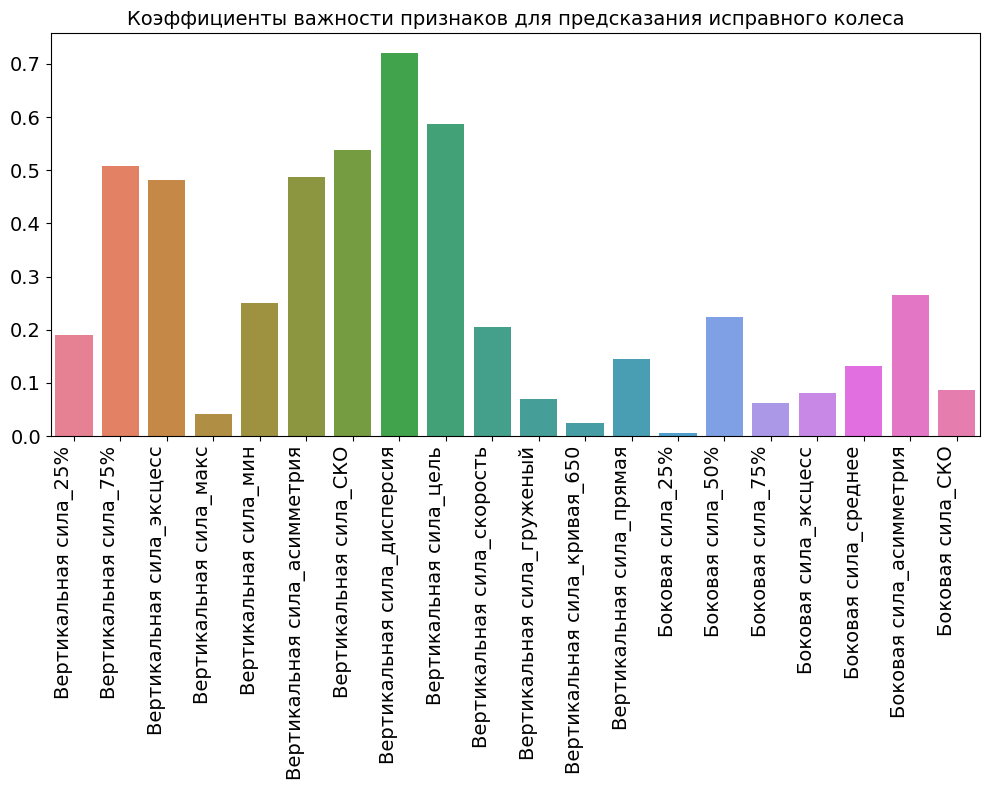

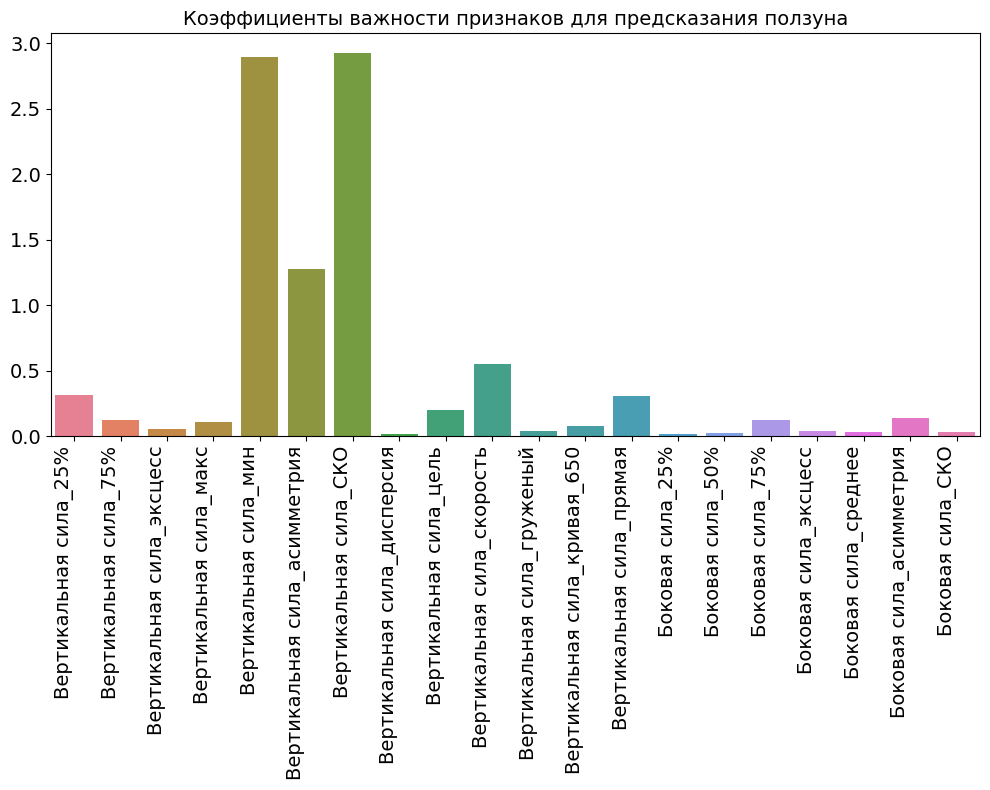

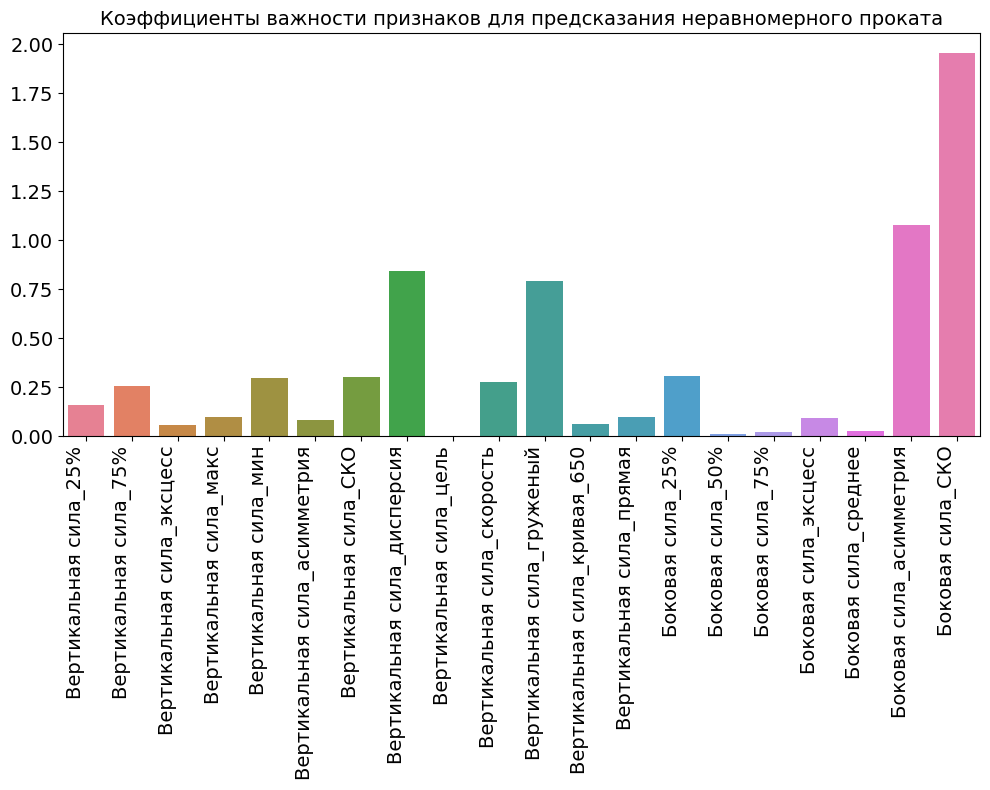

In [39]:
pds.plot_feature_importance(xgb_pipe,column_names=translated_columns,font_size=14)

## Catboost

In [ ]:
from catboost import CatBoostClassifier

params = {
    "CatBoostClassifier__iterations":5,
    "CatBoostClassifier__depth":8,
    "CatBoostClassifier__learning_rate":1.0
}

cat_pipe = Pipeline([("StandardScaler",StandardScaler()),("CatBoostClassifier",CatBoostClassifier())])

cat_pipe.set_params(**params)

cat_pipe.fit(X_train,y_train)


In [ ]:
print(classification_report(y_test,cat_pipe.predict(X_test),digits=digits))

pds.save_results(cat_pipe,X_test,y_test,model_type="vertical",addition=f"params: {params}")

In [ ]:
pds.plot_feature_importance(cat_pipe)

## LightGBM

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.preprocessing import Normalizer

params = {
    "LGBMClassifier__n_estimators":10,
    "LGBMClassifier__max_depth":8,
    "LGBMClassifier__learning_rate":1.0,
    "LGBMClassifier__num_leaves":20
}

lgbm_pipe = Pipeline([("StandardScaler",StandardScaler()),("LGBMClassifier",LGBMClassifier())])

lgbm_pipe.set_params(**params)

lgbm_pipe.fit(X_train,y_train)

print(classification_report(y_test,lgbm_pipe.predict(X_test),digits=digits))

pds.save_results(lgbm_pipe,X_test,y_test,model_type="vertical",addition=f"params: {params}")

In [ ]:
pds.plot_feature_importance(lgbm_pipe)

## Сводка результатов

In [ ]:
pds.show_stat_results()

## AUC_ROC

In [ ]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve, roc_auc_score

fpr,tpr,thresholds = roc_curve(y_true=y_test,y_score=cat_pipe.predict_proba(X_test)[:,1])

auc_roc = roc_auc_score(y_true=y_test,y_score=cat_pipe.predict(X_test))

display = RocCurveDisplay(fpr=fpr,tpr=tpr,roc_auc=auc_roc, estimator_name="Classifier")

display.plot()
plt.show()

In [ ]:
fpr,tpr,thresholds = roc_curve(y_true=y_test,y_score=xgb_pipe.predict_proba(X_test)[:,1])

auc_roc = roc_auc_score(y_true=y_test,y_score=xgb_pipe.predict(X_test))

display = RocCurveDisplay(fpr=fpr,tpr=tpr,roc_auc=auc_roc, estimator_name="XGB Classifier")

display.plot()
plt.show()

**PCA TSNE**

In [ ]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(X)

X_embedded

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.plotting import plot_decision_regions

# Initializing Classifiers
clf = XGBClassifier()


# Loading some example data

# print(X)
# print(y)

# Plotting Decision Regions

gs = gridspec.GridSpec(2, 2)
fig = plt.figure().set_size_inches(12,8)

labels = ['Предсказания модели XGboost']
          

for clf, lab, grd in zip([clf],
                         labels,
                         itertools.product([0, 1],
                         repeat=2)):
    clf.fit(X_embedded, y)
    
    # ax = plt.subplot(gs[grd[0], grd[1]])
    plt.plot(grd[0],grd[1])
    fig = plot_decision_regions(X=X_embedded, y=y.to_numpy(),
                                clf=clf, legend=1)
    plt.title(lab)

plt.show()

# Обучение моделей для диагностирования толщины гребней

In [40]:
from sklearn.model_selection import train_test_split

X_ = DF.drop([('Vertical force', '50%'),
             ('Vertical force','mean'),
             ('Vertical force', "sum"),
             ('Vertical force', "count"),
             ("Side force", "count"),
             ("Side force", "sum"),
             ("Side force", "max"),
             ("Side force", "min"),
             ("Side force", "var"),
             ("Vertical force", "target")],axis=1)

y_ = DF[("Side force", "profile")]

side_translated_columns = [
    "_".join(translation_map.get(part, part) for part in col).strip("_")
    for col in X_.columns
]

side_translated_columns

['Вертикальная сила_25%',
 'Вертикальная сила_75%',
 'Вертикальная сила_эксцесс',
 'Вертикальная сила_макс',
 'Вертикальная сила_мин',
 'Вертикальная сила_асимметрия',
 'Вертикальная сила_СКО',
 'Вертикальная сила_дисперсия',
 'Вертикальная сила_скорость',
 'Вертикальная сила_груженый',
 'Вертикальная сила_кривая_650',
 'Вертикальная сила_прямая',
 'Боковая сила_25%',
 'Боковая сила_50%',
 'Боковая сила_75%',
 'Боковая сила_эксцесс',
 'Боковая сила_среднее',
 'Боковая сила_асимметрия',
 'Боковая сила_СКО',
 'Боковая сила_профиль']

In [41]:
X_train_,X_test_,y_train_,y_test_ = train_test_split(X_,y_,test_size=0.2,shuffle=True)

## XGboost

              precision    recall  f1-score   support

           0  0.99596346 0.99448451 0.99522344     23570
           1  0.98999389 0.99264762 0.99131898     13057
           2  0.99997133 0.99997133 0.99997133     34882

    accuracy                      0.99682557     71509
   macro avg  0.99530956 0.99570116 0.99550458     71509
weighted avg  0.99682850 0.99682557 0.99682653     71509



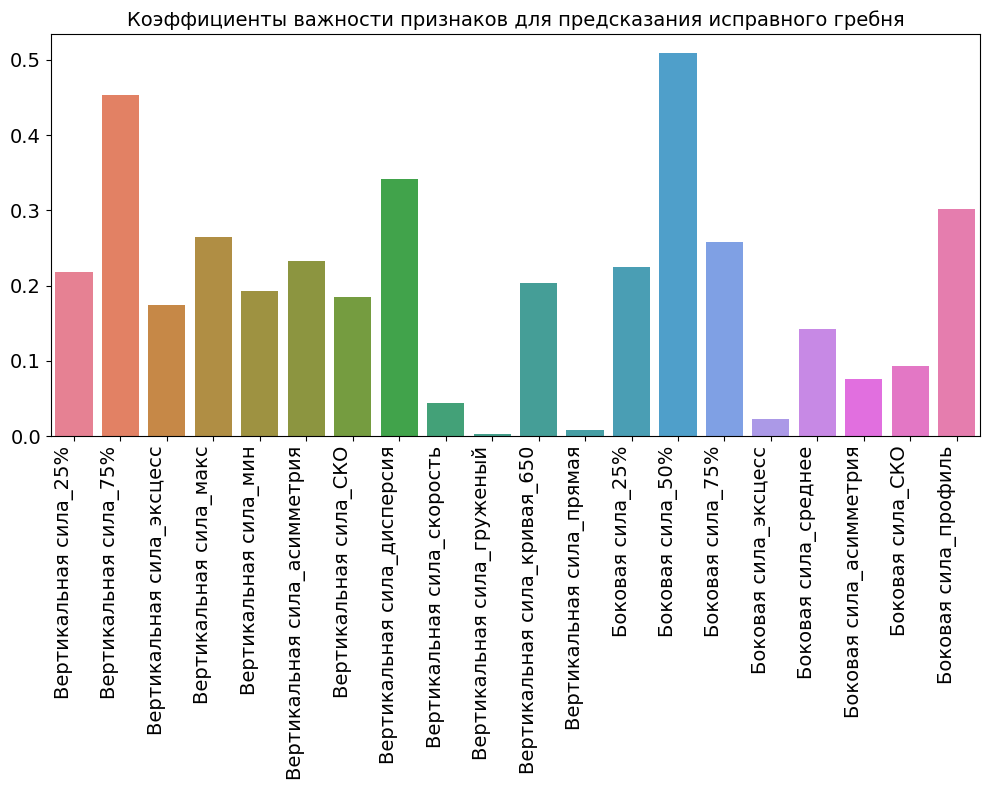

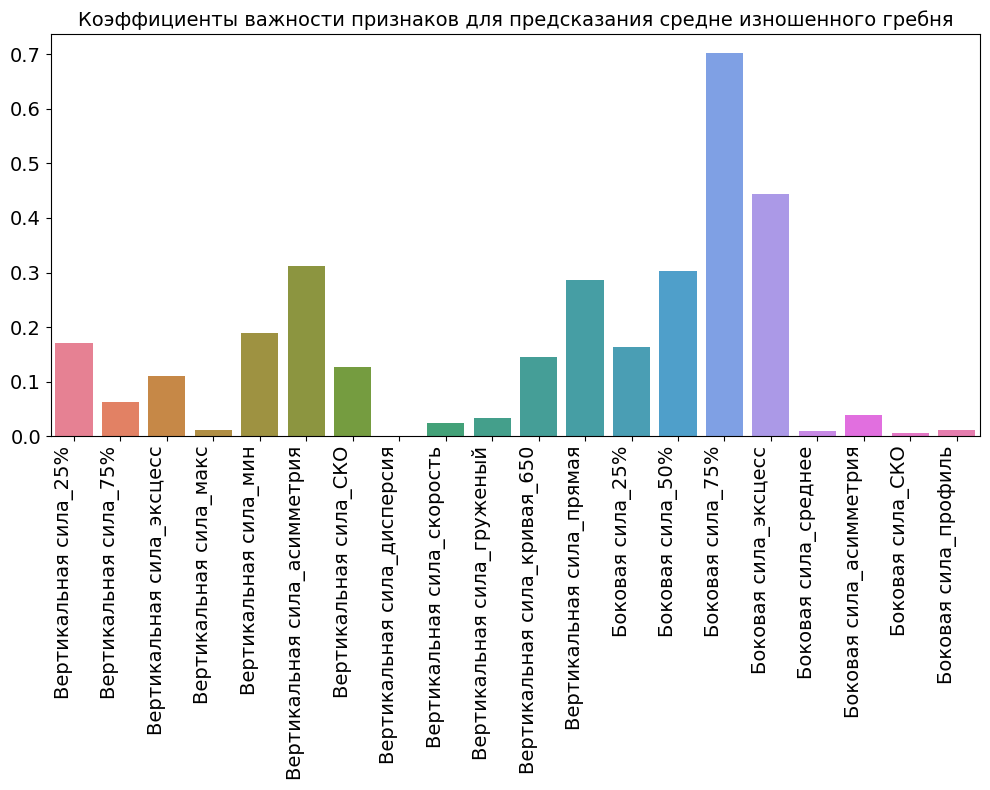

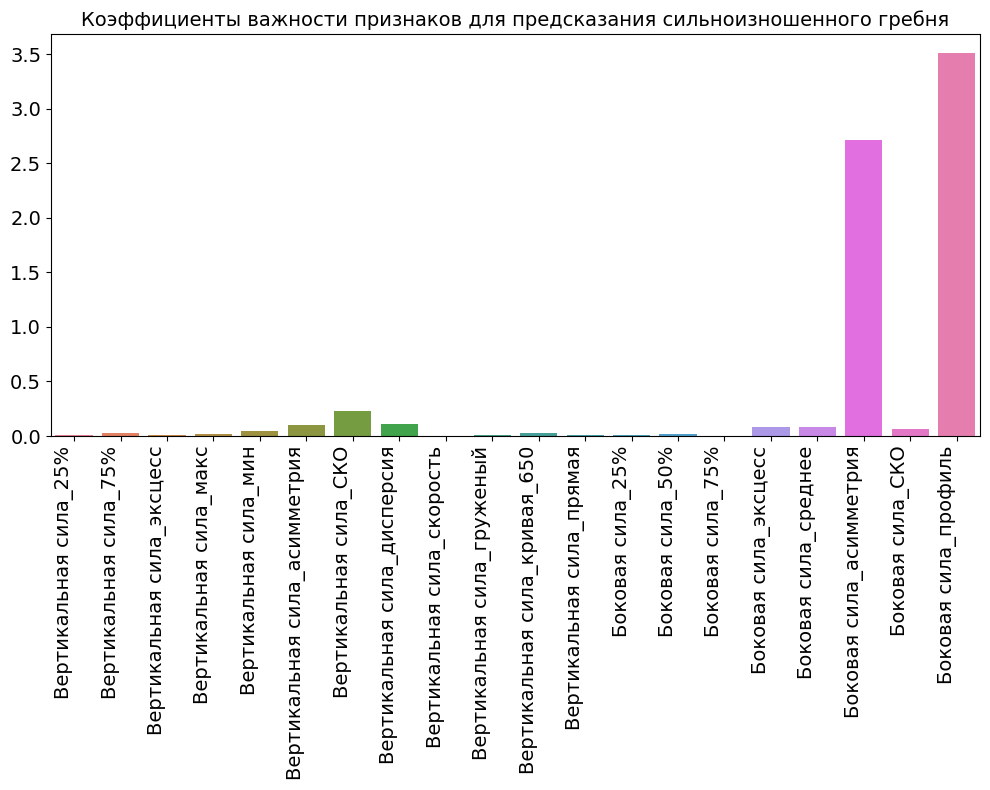

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

params = {
    "XGBClassifier__n_estimators":10,
    "XGBClassifier__booster":"gblinear"
}

profile_xgb_pipe = Pipeline([("StandardScaler",StandardScaler()),("XGBClassifier",XGBClassifier())])

profile_xgb_pipe.set_params(**params)
profile_xgb_pipe.fit(X_train_,y_train_)

print(classification_report(y_test_, profile_xgb_pipe.predict(X_test_),digits=digits))

pds.plot_feature_importance(profile_xgb_pipe,side_translated_columns,font_size=14, profile=True)

pds.save_results(profile_xgb_pipe,X_test_,y_test_,model_type="side",addition=f"params: {params}")

## Catboost

In [ ]:
params = {
    "CatBoostClassifier__iterations":5,
    "CatBoostClassifier__depth":8,
    "CatBoostClassifier__learning_rate":0.5
}

profile_cat_pipe = Pipeline([("StandardScaler",StandardScaler()),("CatBoostClassifier",CatBoostClassifier())])

profile_cat_pipe.set_params(**params)
profile_cat_pipe.fit(X_train_,y_train_)

print(classification_report(y_test_, profile_cat_pipe.predict(X_test_),digits=digits))

pds.plot_feature_importance(profile_cat_pipe)

pds.save_results(profile_cat_pipe,X_test_,y_test_,model_type="side",addition=f"params: {params}")

In [ ]:
print(classification_report(y_test_, profile_cat_pipe.predict(X_test_),digits=digits))

## LightGBM

In [ ]:
params = {
    "LGBMClassifier__n_estimators":10,
    "LGBMClassifier__max_depth":8,
    "LGBMClassifier__learning_rate":1.0,
    "LGBMClassifier__num_leaves":20
}

profile_lgbm_pipe = Pipeline([("StandardScaler",StandardScaler()),("LGBMClassifier",LGBMClassifier())])

profile_lgbm_pipe.set_params(**params)
profile_lgbm_pipe.fit(X_train_,y_train_)

print(classification_report(y_test_,profile_lgbm_pipe.predict(X_test_),digits=digits))

pds.save_results(profile_lgbm_pipe,X_test_,y_test_,model_type="side",addition="default settings")

In [ ]:
pds.plot_feature_importance(profile_lgbm_pipe)

In [ ]:
pds.show_stat_results()